# Library

In [1]:
import numpy as np
from sklearn.preprocessing import normalize
from numpy import linalg as LA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from time import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups
import pandas as pd 
from sklearn.utils.extmath import randomized_svd 
import sys
from tqdm import tqdm
import scipy
from PIL import Image
#import pdb; pdb.set_trace()

# Dataset

In [2]:
# Documents are saves in the TF-IDF format

import joblib
(A,terms,_) = joblib.load( "dataset/articles-tfidf.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )
A=A.toarray()

Loaded 4551 X 10285 document-term matrix


# Constant Value

In [3]:
M=0.2 
eta_H =1e-3 # convergence check for H upadte
max_epoch_H=50
eta_W =1e-4 # convergence check for W update
max_epoch_W =200 


# Function

In [4]:
def nonnegative_projection(A):
    A[A<0]=0
    return A

In [5]:
def update_H_R(W,H,V,N,alpha_h):
    dH=(np.matmul(np.matmul(W.T,W),H)-np.matmul(W.T,(V)))/N
    H_n=H-alpha_h*dH;  
    H_n=nonnegative_projection(H_n)
    H_n=my_normalize_matrix_W(H_n)
    return H_n

In [6]:
def update_W(W,At,Bt,alpha_W):
    dW=np.matmul(W,At)-Bt
    W_n=W-alpha_W*dW 
    W_n=nonnegative_projection(W_n)
    W_n=my_normalize_matrix_W(W_n)
    return W_n
    

In [7]:
def my_normalize_matrix_W(A):
    nrms = np.sqrt(np.sum(A** 2, axis = 0))
    
    max_nrms=np.where(nrms<1,1,nrms)

    A= A/ max_nrms
    return A
    

In [8]:
def loss_calc_h(W,H,V):
    loss=0.5*LA.norm(V-np.matmul(W,H),ord='fro')**2
    return loss

In [9]:
def loass_calc_W(W,At,Bt):
    loss=0.5*np.trace(W.T @ W @ At) - np.trace(W.T @ Bt)
    return loss

In [10]:
def objective_calc(W,H,V):
    loss=0.5*LA.norm((V-np.matmul(W,H)),ord='fro')**2
    return loss

In [11]:
def early_stop(loss_prev,loss_current,eta):

    if ((loss_current-loss_prev)/loss_prev) < eta:
        return 1
    else:
        return 0
    

In [12]:
def optimize_H_R(W,H,V,N,eta_h,max_epoch_h,alpha_h):
    epoch=0
    while(1):
        epoch+=1
        loss_prev=loss_calc_h(W,H,V)/N
        #print(f'loss_prev {loss_prev.shape}')
        H=update_H_R(W,H,V,N,alpha_h)
        loss_current=loss_calc_h(W,H,V)/N
        if early_stop(loss_prev,loss_current,eta_h) or (epoch>max_epoch_h):
            break     
    return H

In [13]:
def optimize_W(W,At,Bt,eta_W,max_epoch_W,alpha_W):
    epoch=0
    while(1):
        epoch+=1
        loss_prev=loass_calc_W(W,At,Bt)
        W=update_W(W,At,Bt,alpha_W)
        loss_current=loass_calc_W(W,At,Bt)
        if early_stop(loss_prev,loss_current,eta_W) or (epoch>max_epoch_W) :            
             break
    return W

In [14]:
def call_noise(epsilon,delta,Delf,m,n):
    sigma = (Delf/epsilon) * np.sqrt(2 * np.log(1.25/delta))
    noise = sigma * np.random.randn(m,n)
    return noise

In [15]:
def overall_epsion(K,Delf,epsilon,delta):
    sigma=calc_sigma(Delf,epsilon,delta)
    optimum_alpha=calc_optimum_alpha(K,sigma,delta,Delf)
    overall_epsilon=calc_overall_epsilon(optimum_alpha,K,sigma,delta,Delf)
    return overall_epsilon

def calc_sigma(Delf,epsilon,delta):
    sigma = (Delf/epsilon) * np.sqrt(2 * np.log(1.25/delta))
    return sigma

def calc_optimum_alpha(K,sigma,delta,Delf):
    optimum_alpha=1+np.sqrt(((sigma**2)/(K*Delf**2))*np.log(1/delta))
    return optimum_alpha

def calc_overall_epsilon(alpha,K,sigma,delta,Delf):
    overall_epsilon=((alpha*K*Delf**2)/(sigma**2))+((np.log(1/delta))/(alpha-1))
    return overall_epsilon

In [16]:
def plot_top_words(W, feature_names, n_top_words, title,text):
    fig, axes = plt.subplots(2, 4, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    #print(model.components_.shape)
    for topic_idx, topic in enumerate(W.T):
        #print(topic_idx)
        #print(topic)
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]*10

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        #fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(text, bbox_inches='tight')
    plt.show()

In [17]:
def norm(x):
    y=np.sqrt(np.sum(x**2))
    return y

In [18]:
# From scikit-learn Initialization

def initialization(V,k):
    
    U, S, V_new = randomized_svd(V, k, random_state=1)
    W = np.zeros_like(U)
    H = np.zeros_like(V_new)
    W[:, 0] = np.sqrt(S[0]) * np.abs(U[:, 0])
    H[0, :] = np.sqrt(S[0]) * np.abs(V_new[0, :])
    
    for j in range(1, k):
        x, y = U[:, j], V_new[j, :]

        # extract positive and negative parts of column vectors
        x_p, y_p = np.maximum(x, 0), np.maximum(y, 0)
        x_n, y_n = np.abs(np.minimum(x, 0)), np.abs(np.minimum(y, 0))

        # and their norms
        x_p_nrm, y_p_nrm = norm(x_p), norm(y_p)
        x_n_nrm, y_n_nrm = norm(x_n), norm(y_n)

        m_p, m_n = x_p_nrm * y_p_nrm, x_n_nrm * y_n_nrm

        # choose update
        if m_p > m_n:
            u = x_p / x_p_nrm
            v = y_p / y_p_nrm
            sigma = m_p
        else:
            u = x_n / x_n_nrm
            v = y_n / y_n_nrm
            sigma = m_n

        lbd = np.sqrt(S[j] * sigma)
        W[:, j] = lbd * u
        H[j, :] = lbd * v

        
    W=nonnegative_projection(W)
    H=nonnegative_projection(H)
    
    return W,H

In [19]:
def call_noise(epsilon,delta,Delf,m,n):
    sigma = (Delf/epsilon) * np.sqrt(2 * np.log(1.25/delta))
    noise = sigma * np.random.randn(m,n)
    return noise

# Train

In [20]:
def nmf(V,K,training_parameter):
    
    
    epoch_num=training_parameter["epoch_num"]
    topic_num=training_parameter["topic_num"]
    alpha_W=training_parameter["alpha_W"] 
    alpha_H=training_parameter["alpha_H"]

    M=training_parameter["M"]
    eta_H=training_parameter["eta_H"]
    max_epoch_h=training_parameter["max_epoch_H"]
    eta_W =training_parameter["eta_W"]
    max_epoch_W=training_parameter["max_epoch_W"] 
    
    D=V.shape[0] # Raw data dimension
    N=V.shape[1] # Number of documents
    
    W,H=initialization(V,K)
    W=my_normalize_matrix_W(W)
    H=my_normalize_matrix_W(H)
    At=np.zeros((K,K))
    Bt=np.zeros((D,K))
    
    loss=np.zeros(epoch_num)

    for idx,epoch in enumerate (tqdm(range (epoch_num))):
        
        loss[idx]=objective_calc(W,H,V)/N
        
        H=optimize_H_R(W,H,V,N,eta_H,max_epoch_H,alpha_H)
        

        At= (H @ H.T)/N
        Bt=((V) @ H.T)/N
        
        W=optimize_W(W,At,Bt,eta_W,max_epoch_W,alpha_W)

    return W,H,loss
    

In [21]:
epoch_num=1000
topic_num=8
alpha_W=20 # learning rate
alpha_H=20 # learning rate

M=0.2 
eta_H =1e-3 # convergence check for H upadte
max_epoch_H=50
eta_W =1e-4 # convergence check for W update
max_epoch_W =200 


training_parameter={"epoch_num":epoch_num,
                   "alpha_W":alpha_W,
                   "alpha_H":alpha_H,
                   "eta_H":eta_H,
                   "eta_W":eta_W,
                   "max_epoch_H":max_epoch_H,
                   "max_epoch_W":max_epoch_W,
                   "M":M,
                   "topic_num":topic_num
                   }

W,H,loss=nmf(A.T,topic_num,training_parameter)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [36:12<00:00,  2.17s/it]


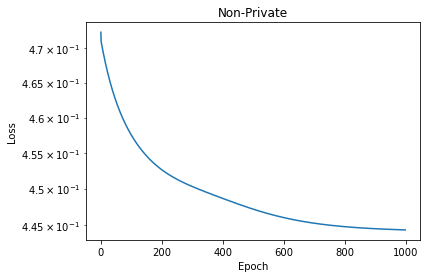

In [22]:
plt.semilogy(range(len(loss)),loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Non-Private")
plt.grid(False)

# plt.savefig("without_privacy.pdf", bbox_inches='tight')

# Topic show

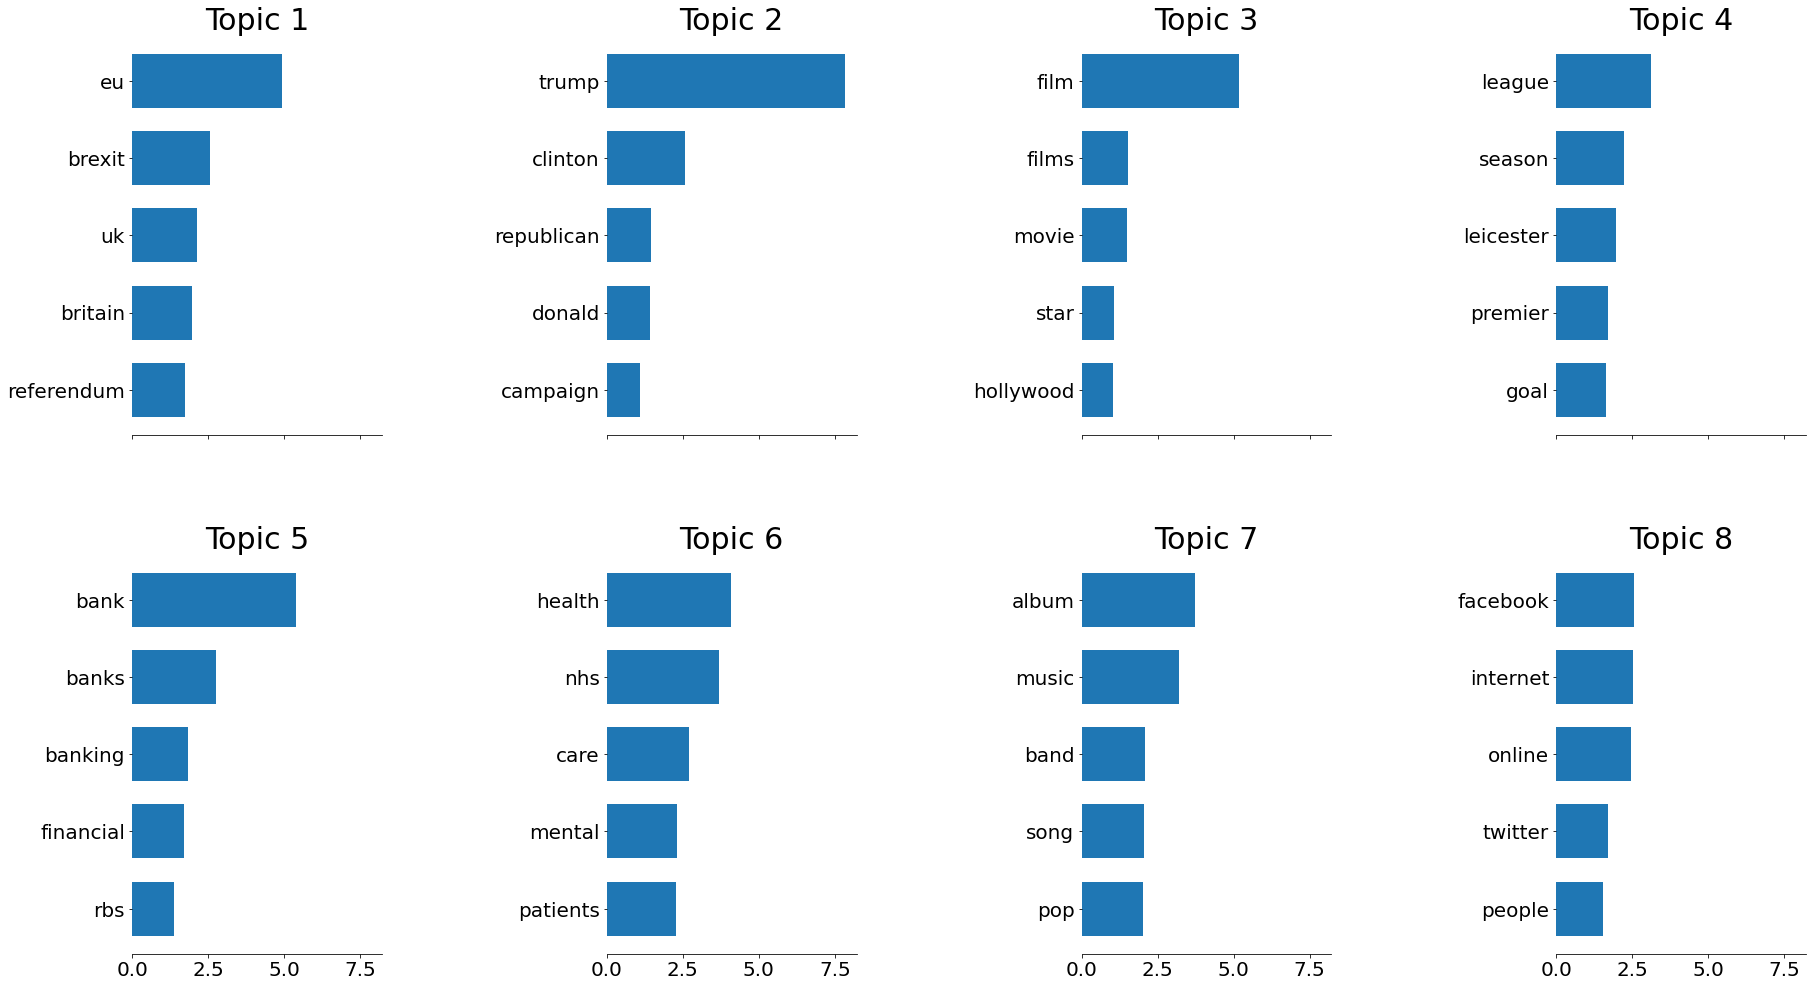

In [23]:
plot_top_words(W, terms, 5,'avb',"topic_uci_w_o_noise.pdf")

# DP Privacy Training

In [24]:
def nmf_privacy_tarining(V,K,training_parameter_private):
   
    
    epoch_num=training_parameter_private["epoch_num"]
    topic_num=training_parameter_private["topic_num"]
    alpha_W=training_parameter_private["alpha_W"] 
    alpha_H=training_parameter_private["alpha_H"]

    M=training_parameter_private["M"]
    eta_H=training_parameter_private["eta_H"]
    max_epoch_h=training_parameter_private["max_epoch_H"]
    eta_W =training_parameter_private["eta_W"]
    max_epoch_W=training_parameter_private["max_epoch_W"] 
    
    epsilon_list=training_parameter_private["epsilon_list"]
    delta=training_parameter_private["delta"]
    average_num=training_parameter_private["average_num"]
    
    D=V.shape[0] # Raw data dimension
    N=V.shape[1] # Number of documents
    
    sensitivity=2/N
    

    loss_privacy=np.zeros((average_num,epoch_num,len(epsilon_list)))
    W_store=np.zeros((D,K,len(epsilon_list)))
    H_store=np.zeros((K,N,len(epsilon_list)))
    

    for epsilon_index, epsilon in enumerate((epsilon_list)):
        print(f'epsilon: {epsilon}')
        for avg_index in range(average_num):
            
            W,H=initialization(V,K)
            
#             W=W_old[:,:,epsilon_index]
#             H=H_old[:,:,epsilon_index]
            
            W=my_normalize_matrix_W(W)
            H=my_normalize_matrix_W(H)
            
            At=np.zeros((K,K))
            Bt=np.zeros((D,K))


            for epoch_idx,epoch in enumerate (tqdm((range (epoch_num)))):
                loss_privacy[avg_index,epoch_idx,epsilon_index]=objective_calc(W,H,V)/N

              
                H=optimize_H_R(W,H,V,N,eta_H,max_epoch_H,alpha_H)

                #print(' h @ r optimization is done')

                At= (H @ H.T)/N
                At_noise=At+call_noise(epsilon,delta,sensitivity,At.shape[0],At.shape[1])
                Bt=((V) @ H.T)/N
                Bt_noise=Bt+call_noise(epsilon,delta,sensitivity,Bt.shape[0],Bt.shape[1])
                W=optimize_W(W,At_noise,Bt_noise,eta_W,max_epoch_W,alpha_W)
                
                if (epoch==epoch_num-1): # store W for last epoch value 
                    W_store[:,:,epsilon_index]=W_store[:,:,epsilon_index]+W
                    H_store[:,:,epsilon_index]=H_store[:,:,epsilon_index]+H




    loss_privacy=loss_privacy.mean(axis=0)
    
    W_store=W_store/average_num
    H_store=H_store/average_num
    
    return loss_privacy,W_store,H_store



In [25]:
epoch_num=1500
topic_num=8
average_num=1
alpha_W_private=0.0001
alpha_H_private=20
epsilon_list=[0.5,0.6,0.7,0.8,0.9,0.999]
delta = 1e-5

training_parameter_private={"epoch_num":epoch_num,
                   "alpha_W":alpha_W_private,
                   "alpha_H":alpha_H_private,
                   "eta_H":eta_H,
                   "eta_W":eta_W,
                   "max_epoch_H":max_epoch_H,
                   "max_epoch_W":max_epoch_W,
                   "M":M,
                   "topic_num":topic_num,
                   "epsilon_list":epsilon_list,
                   "delta":delta,
                   "average_num":average_num     
                   }


loss_privacy,W_privacy,H_privacy=nmf_privacy_tarining(A.T,topic_num,training_parameter_private)

epsilon: 0.5


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [1:03:20<00:00,  2.53s/it]


epsilon: 0.6


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [1:23:37<00:00,  3.34s/it]


epsilon: 0.7


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [1:03:41<00:00,  2.55s/it]


epsilon: 0.8


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [1:05:05<00:00,  2.60s/it]


epsilon: 0.9


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [1:01:27<00:00,  2.46s/it]


epsilon: 0.999


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [1:01:24<00:00,  2.46s/it]


# Plot the loss graph

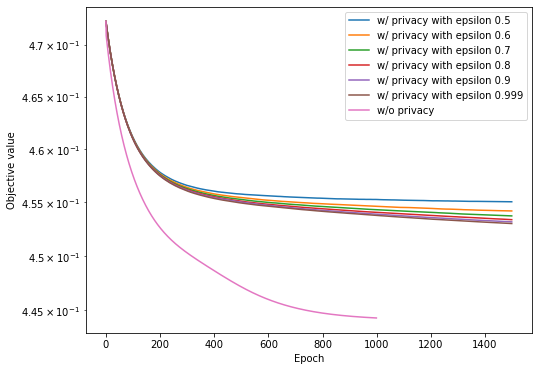

In [26]:
#loss_privacy=loss_privacy.mean(axis=0)


plt.figure(figsize=(8,6))

for epsilon_index, epsilon in enumerate(epsilon_list):
    plt.semilogy(range(len(loss_privacy[:,epsilon_index])),loss_privacy[:,epsilon_index],label=f'w/ privacy with epsilon {epsilon}')
    
plt.semilogy(range(len(loss[:])),loss[:],label='w/o privacy')
plt.xlabel("Epoch")
plt.ylabel("Objective value")
plt.legend(loc="upper right",fontsize='10')
plt.grid(False)
plt.show()

# Topic Word Private

In [27]:
# plot_top_words( W_privacy_store[:,:,0], terms, 5,'avb',"topic_uci_w_noise.pdf")